# Forest Loss Driver Analysis (Northern Maine Acaduab Reguib)

**Goal:** Use a Random Forest model to identify the relative importance of
preceding spectral conditions and climate variables in predicting forest loss
events (from Hansen GFC) between 2001 and 2021.

**Data:**
- Annual Landsat C02 L2 median composites (2000-2021), Bands: B, G, R, NIR, SWIR1, SWIR2, NDVI, NBR
- Hansen GFC Loss Year (2000-2021 v1.9)
- Hansen GFC Tree Cover 2000
- Annual TerraClimate: Mean Temperature, Total Precipitation (2000-2021)
- SRTM DEM & Slope

**Methodology:**
1. Load and verify data alignment (CRS, Extent, Resolution).
2. Define sampling strategy: Sample loss pixels and non-loss pixels (within forest mask) annually.
3. Extract features for sampled pixels:
   - Target: Loss in year `t` (binary)
   - Features: Landsat(t-1), Climate(t-1), Climate(t), DEM, Slope
4. Split data temporally (e.g., train 2001-2015, test 2016-2021).
5. Train Random Forest Classifier.
6. Evaluate model performance.
7. Analyze feature importances.

# Abstract

This project details the development of a machine learning pipeline to analyze drivers of non-fire related forest loss in the Acadian region (Northern Maine study area, 2001-2021). Following a project re-scoping for solo completion in mid-April 2025, the work built upon prior group explorations into spectral tree species classification using Sentinel-2 imagery and GBIF occurrence data. These initial attempts encountered significant challenges including species data sparsity, high spectral similarity among target species, and critical technical failures in spectral signature extraction (e.g., a key script iteration reported 100% of ∼7,700 GBIF points as outside image boundaries), leading to low preliminary model performance (e.g., ~29% RF accuracy for species ID).
This necessitated a strategic pivot to a more robust analysis of aggregate annual forest loss events derived from the Hansen Global Forest Change dataset, predicted using a Random Forest classifier. Predictor features include time-lagged Landsat Collection 2 Level 2 annual composites (spectral bands and vegetation indices like NDVI/NBR), annual TerraClimate data (mean temperature, total precipitation), and static SRTM topographic data (elevation, slope), all processed and aligned to a 30m grid.
Key methodological steps documented include: data acquisition via Google Earth Engine; pre-processing, notably the local merging of GEE-tiled Landsat exports using gdal_merge.py and rigorous data alignment verification; various pixel sampling approaches, including aggressive downsampling for a Minimum Viable Product (MVP) run to manage extensive NaN values encountered in feature data and for rapid pipeline testing; feature engineering with mean imputation for NaNs; and a temporal train/test split for evaluation.



## 1. Setup and Imports

In [ ]:
import os
import glob
from pathlib import Path
import time 

import numpy as np
import pandas as pd
import rasterio
from rasterio.windows import Window
from rasterio.enums import Resampling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
import joblib 



print("Libraries imported.")

Libraries imported.


## 2. Configuration and Constants

In [ ]:

import os
from pathlib import Path


PROJECT_ROOT = Path('/Users/benjaminpace/MLCS/mlcs') 

print(f"Attempting to use Project Root: {PROJECT_ROOT}")
if not (PROJECT_ROOT / 'data').exists():
    current_dir = Path(os.getcwd())
    if current_dir.name == 'notebooks' and (current_dir.parent / 'data').exists():
        PROJECT_ROOT = current_dir.parent
        print(f"Adjusted Project Root (inferred): {PROJECT_ROOT}")
    else:
        raise FileNotFoundError(
            f"CRITICAL: 'data' directory not found relative to an assumed Project Root of {PROJECT_ROOT}. "
            f"Please verify the PROJECT_ROOT variable in this cell. Current directory is {os.getcwd()}."
        )
else:
    print(f"Project Root confirmed: {PROJECT_ROOT}")


DATA_DIR = PROJECT_ROOT / 'data'
LANDSAT_DIR = DATA_DIR / 'landsat'
HANSEN_DIR = DATA_DIR / 'hansen'
CLIMATE_DIR = DATA_DIR / 'climate'
AUX_DIR = DATA_DIR / 'aux'
OUTPUT_DIR = PROJECT_ROOT / 'output'
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Data Directory: {DATA_DIR}")
print(f"Landsat Directory: {LANDSAT_DIR}")
print(f"Hansen Directory: {HANSEN_DIR}")
print(f"Climate Directory: {CLIMATE_DIR}")
print(f"Auxiliary Directory: {AUX_DIR}")
print(f"Output Directory: {OUTPUT_DIR}")

HANSEN_LOSS_YEAR_PATH = HANSEN_DIR / 'hansen_lossyear_2000_2021.tif'
HANSEN_COVER_2000_PATH = HANSEN_DIR / 'hansen_treecover_2000.tif'
DEM_PATH = AUX_DIR / 'dem.tif'
SLOPE_PATH = AUX_DIR / 'slope.tif'

START_YEAR = 2001 # First year for which we predict loss (uses t-1 predictors from 2000)
END_YEAR = 2002     # Last target year for loss. Targets: 2001, 2002 ONLY.

YEARS = list(range(START_YEAR, END_YEAR + 1))
print(f"Analysis Target Years (YEARS): {YEARS}") # Should be [2001, 2002]

LANDSAT_BANDS = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'NDVI', 'NBR']
print(f"Expected Landsat Bands (in order): {LANDSAT_BANDS}")

CLIMATE_VARS = ['mean_temp', 'total_precip']
print(f"Climate Variables: {CLIMATE_VARS}")

STATIC_VARS = ['dem', 'slope'] 
print(f"Static Variables: {STATIC_VARS}")

NON_LOSS_RATIO = 1
MIN_TREE_COVER = 30
RANDOM_STATE = 42

TEST_SPLIT_YEAR = 2002   
print(f"Test Split Year (targets < this year for train): {TEST_SPLIT_YEAR}")

RF_N_ESTIMATORS = 10
RF_MAX_DEPTH = 5
RF_MIN_SAMPLES_LEAF = 50
RF_MIN_SAMPLES_SPLIT = 100
RF_N_JOBS = -1

Attempting to use Project Root: /Users/benjaminpace/MLCS/mlcs
Project Root confirmed: /Users/benjaminpace/MLCS/mlcs
Data Directory: /Users/benjaminpace/MLCS/mlcs/data
Landsat Directory: /Users/benjaminpace/MLCS/mlcs/data/landsat
Hansen Directory: /Users/benjaminpace/MLCS/mlcs/data/hansen
Climate Directory: /Users/benjaminpace/MLCS/mlcs/data/climate
Auxiliary Directory: /Users/benjaminpace/MLCS/mlcs/data/aux
Output Directory: /Users/benjaminpace/MLCS/mlcs/output
Analysis Target Years (YEARS): [2001, 2002]
Expected Landsat Bands (in order): ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'NDVI', 'NBR']
Climate Variables: ['mean_temp', 'total_precip']
Static Variables: ['dem', 'slope']
Test Split Year (targets < this year for train): 2002


## 3. Data Loading and Verification

**CRITICAL STEP:** Verify that all input rasters have the *exact same* Coordinate Reference System (CRS), transform (affine), dimensions (width, height), and resolution.

In [ ]:

import rasterio 
from pathlib import Path 

def verify_raster_alignment(raster_paths):
    """Checks CRS, transform, shape of multiple rasters."""
    print("Verifying raster alignment...")
    if not raster_paths:
        print("  No raster paths provided for verification.")
        return None

    reference_profile = None
    all_aligned = True 
    checked_paths_count = 0

    for path_obj in raster_paths:
        path_str = str(path_obj) #
        current_file_path = Path(path_str)

        if not current_file_path.exists():
            print(f"  WARNING: File not found, skipping: {current_file_path.name}")
            # If a file is missing, we can't confirm alignment with it.
            # Depending on strictness, you might want to set all_aligned = False here.
            # For now, we'll just skip it and report issues with files that *do* exist.
            continue

        checked_paths_count += 1
        try:
            with rasterio.open(current_file_path) as src:

                current_dtype = src.dtypes[0] 
                profile = {
                    'path_name': current_file_path.name, # Store only name for cleaner printing
                    'crs': src.crs,
                    'transform': src.transform,
                    'width': src.width,
                    'height': src.height,
                    'count': src.count,         # Number of bands
                    'dtype_band1': current_dtype # Data type of the first band
                }
                print(f"--- Checking: {profile['path_name']} ---")



                if reference_profile is None: # This is the first valid file encountered
                    reference_profile = profile
                    print(f"  Set as Reference: CRS={profile['crs']}, Shape=({profile['height']},{profile['width']}), Transform={profile['transform']}")
                else:
                    # Compare current file's profile to the reference profile
                    if profile['crs'] != reference_profile['crs']:
                        print(f"  MISMATCH: CRS ({profile['crs']}) differs from reference ({reference_profile['crs']})")
                        all_aligned = False
                    if profile['transform'] != reference_profile['transform']:
 
                        if not profile['transform'].almost_equals(reference_profile['transform']):
                             print(f"  MISMATCH: Transform differs significantly from reference.")
                             all_aligned = False
                    if profile['width'] != reference_profile['width'] or profile['height'] != reference_profile['height']:
                        print(f"  MISMATCH: Shape ({profile['height']},{profile['width']}) differs from reference ({reference_profile['height']},{reference_profile['width']})")
                        all_aligned = False
                    # We don't strictly need to check band count or dtype for *alignment*,
                    # but they are good to be aware of. The band count will be checked later.

        except Exception as e:
            print(f"  ERROR reading or processing {current_file_path.name}: {type(e).__name__} - {e}")
            all_aligned = False # Treat any read error as an alignment failure for that file

    if checked_paths_count == 0:
        print("\nERROR: No files were found or could be opened for verification.")
        return None

    if reference_profile is None:
        print("\nERROR: No valid reference raster could be established (all checked files had errors or were missing).")
        return None

    if all_aligned:
        print(f"\nSUCCESS: All {checked_paths_count} checked rasters appear ALIGNED with the reference '{reference_profile['path_name']}'.")
        # Return the common profile derived from the reference (excluding its own path name)
        return {key: value for key, value in reference_profile.items() if key != 'path_name'}
    else:
        print("\nERROR: Raster alignment check FAILED for one or more files. Please review MISMATCH messages above.")
        return None

In [ ]:


files_to_check = [
    # Base Layers
    HANSEN_LOSS_YEAR_PATH,
    HANSEN_COVER_2000_PATH,
    DEM_PATH,          # Kept as it had 0 NaNs in previous debug
    SLOPE_PATH,      


    LANDSAT_DIR / 'landsat_composite_2000.tif',
    LANDSAT_DIR / 'landsat_composite_2001.tif',

    # Climate Predictors (t-1) and Concurrent Climate (t):
    # Year 2000 (t-1 for target 2001)
    CLIMATE_DIR / 'mean_temp_2000.tif',
    CLIMATE_DIR / 'total_precip_2000.tif',
    # Year 2001 (t-1 for target 2002; t for target 2001)
    CLIMATE_DIR / 'mean_temp_2001.tif',
    CLIMATE_DIR / 'total_precip_2001.tif',
    # Year 2002 (t for target 2002)
    CLIMATE_DIR / 'mean_temp_2002.tif',
    CLIMATE_DIR / 'total_precip_2002.tif',
]

print("Files to be checked for alignment (ensure these exist in your project structure):")
all_files_exist = True
for f_path in files_to_check:
    exists = Path(f_path).exists()
    print(f"  - {f_path} (Exists: {exists})")
    if not exists:
        all_files_exist = False

if not all_files_exist:
    raise FileNotFoundError(
        "CRITICAL: One or more files listed in 'files_to_check' do not exist at the specified path. "
        "Verify your data movement and file naming."
    )
else:
    print("\nAll listed files exist. Proceeding with alignment check...")

common_profile = verify_raster_alignment(files_to_check) 

assert common_profile is not None, \
    "CRITICAL: Raster alignment check failed. Stopping execution. " \
    "Review errors printed by 'verify_raster_alignment' above. " \
    "All listed files must be perfectly aligned (CRS, Transform, Dimensions)."

RASTER_HEIGHT = common_profile['height']
RASTER_WIDTH = common_profile['width']
RASTER_TRANSFORM = common_profile['transform']
RASTER_CRS = common_profile['crs']

print(f"\nCommon Raster Shape: ({RASTER_HEIGHT}, {RASTER_WIDTH})")
print(f"Common CRS: {RASTER_CRS}")
print(f"Common Transform: {RASTER_TRANSFORM}")

try:
    landsat_to_check_bands = LANDSAT_DIR / 'landsat_composite_2000.tif'
    if landsat_to_check_bands.exists():
        with rasterio.open(landsat_to_check_bands) as src:
            print(f"\nVerifying bands for: {landsat_to_check_bands.name}")
            print(f"  Number of bands found in file: {src.count}")
            print(f"  Expected number of bands (from LANDSAT_BANDS variable): {len(LANDSAT_BANDS)}")
            if src.count != len(LANDSAT_BANDS):
                print(f"  WARNING: Band count mismatch! Code expects {len(LANDSAT_BANDS)} based on LANDSAT_BANDS list.")
    else:
        print(f"WARNING: Cannot check bands, {landsat_to_check_bands.name} not found for this check.")
except Exception as e:
    print(f"\nCould not perform Landsat band count/description check: {type(e).__name__} - {e}")

Files to be checked for alignment (ensure these exist in your project structure):
  - /Users/benjaminpace/MLCS/mlcs/data/hansen/hansen_lossyear_2000_2021.tif (Exists: True)
  - /Users/benjaminpace/MLCS/mlcs/data/hansen/hansen_treecover_2000.tif (Exists: True)
  - /Users/benjaminpace/MLCS/mlcs/data/aux/dem.tif (Exists: True)
  - /Users/benjaminpace/MLCS/mlcs/data/aux/slope.tif (Exists: True)
  - /Users/benjaminpace/MLCS/mlcs/data/landsat/landsat_composite_2000.tif (Exists: True)
  - /Users/benjaminpace/MLCS/mlcs/data/landsat/landsat_composite_2001.tif (Exists: True)
  - /Users/benjaminpace/MLCS/mlcs/data/climate/mean_temp_2000.tif (Exists: True)
  - /Users/benjaminpace/MLCS/mlcs/data/climate/total_precip_2000.tif (Exists: True)
  - /Users/benjaminpace/MLCS/mlcs/data/climate/mean_temp_2001.tif (Exists: True)
  - /Users/benjaminpace/MLCS/mlcs/data/climate/total_precip_2001.tif (Exists: True)
  - /Users/benjaminpace/MLCS/mlcs/data/climate/mean_temp_2002.tif (Exists: True)
  - /Users/benjam

## 4. Sampling Strategy

For each year `t` from 2001 to 2021:
1. Identify pixels where loss occurred exactly in year `t`.
2. Identify pixels that are potential non-loss candidates (forested in 2000, no loss 2001-2021).
3. Sample loss pixels.
4. Sample `NON_LOSS_RATIO` times as many non-loss pixels randomly from the candidates.
5. Store pixel coordinates (row, col) and associated target year/loss status.

In [ ]:
all_sampled_points = []

print("Starting pixel sampling...")
sampling_start_time = time.time()


try:
    print("Loading base data for sampling (Hansen Loss Year and Cover 2000)...")
    with rasterio.open(HANSEN_LOSS_YEAR_PATH) as loss_src:
        # Verify shape matches common profile before reading
        assert (loss_src.height, loss_src.width) == (RASTER_HEIGHT, RASTER_WIDTH), \
            f"Loss year shape ({loss_src.height},{loss_src.width}) mismatch with common profile ({RASTER_HEIGHT},{RASTER_WIDTH})!"
        loss_year_data = loss_src.read(1)
        print(f"  Loaded Loss Year data ({loss_src.height}x{loss_src.width})")

    with rasterio.open(HANSEN_COVER_2000_PATH) as cover_src:
        assert (cover_src.height, cover_src.width) == (RASTER_HEIGHT, RASTER_WIDTH), \
            f"Cover 2000 shape ({cover_src.height},{cover_src.width}) mismatch with common profile ({RASTER_HEIGHT},{RASTER_WIDTH})!"
        cover_2000_data = cover_src.read(1)
        print("  Loaded Tree Cover 2000 data")


    # Condition 1: Sufficient tree cover in 2000
    forest_mask = cover_2000_data >= MIN_TREE_COVER
    # Condition 2: No loss recorded between 2001 and 2021 (loss year == 0 in Hansen)
    no_loss_mask = loss_year_data == 0
    # Combined mask for pixels eligible to be sampled as "non-loss" controls
    non_loss_candidate_mask = forest_mask & no_loss_mask
    # Get indices (row, col arrays) where mask is True
    non_loss_candidate_indices = np.where(non_loss_candidate_mask)
    num_non_loss_candidates = len(non_loss_candidate_indices[0])
    print(f"Found {num_non_loss_candidates} potential non-loss candidate pixels.")

    # Check if we have candidates to sample from
    if num_non_loss_candidates == 0:
        raise ValueError("No non-loss candidate pixels found based on criteria. Cannot sample.")

    np.random.seed(RANDOM_STATE) # for reproducibility

    for year_num, target_year in enumerate(YEARS):
        start_time_year = time.time()
        print(f"\n--- Sampling for target year: {target_year} ---")


        hansen_loss_code = target_year - 2000
        loss_pixels_this_year_mask = loss_year_data == hansen_loss_code
        loss_indices_this_year = np.where(loss_pixels_this_year_mask)
        num_loss_pixels = len(loss_indices_this_year[0])
        print(f"  Found {num_loss_pixels} loss pixels.")

        if num_loss_pixels == 0:
            print("  No loss pixels found for this year. Skipping sampling for this year.")
            continue

        # Add loss pixels to sample list
        for r, c in zip(loss_indices_this_year[0], loss_indices_this_year[1]):
            all_sampled_points.append({'row': r, 'col': c, 'target_year': target_year, 'loss': 1})

        # Sample non-loss pixels
        # Calculate how many non-loss points to sample for this year
        num_non_loss_to_sample = min(num_non_loss_candidates, num_loss_pixels * NON_LOSS_RATIO)
        print(f"  Sampling {num_non_loss_to_sample} non-loss pixels (NON_LOSS_RATIO={NON_LOSS_RATIO}).")

        if num_non_loss_to_sample > 0:
            sampled_candidate_indices_idx = np.random.choice(
                num_non_loss_candidates, num_non_loss_to_sample, replace=False # No replacement
            )
            sampled_non_loss_rows = non_loss_candidate_indices[0][sampled_candidate_indices_idx]
            sampled_non_loss_cols = non_loss_candidate_indices[1][sampled_candidate_indices_idx]

            # Add non-loss pixels to sample list
            for r, c in zip(sampled_non_loss_rows, sampled_non_loss_cols):
                all_sampled_points.append({'row': r, 'col': c, 'target_year': target_year, 'loss': 0})
        
        current_total_points = len(all_sampled_points)
        points_this_year = num_loss_pixels + num_non_loss_to_sample
        print(f"  Finished sampling for {target_year}. Points this year: {points_this_year}. Cumulative: {current_total_points}. Time: {time.time() - start_time_year:.2f}s")

    del loss_year_data, cover_2000_data, forest_mask, no_loss_mask, non_loss_candidate_mask
    del loss_pixels_this_year_mask, loss_indices_this_year # non_loss_candidate_indices is large too
    if 'non_loss_candidate_indices' in locals(): del non_loss_candidate_indices
    import gc
    gc.collect() # Try to free memory

    if all_sampled_points: # Only shuffle if list is not empty
        all_sampled_points = shuffle(all_sampled_points, random_state=RANDOM_STATE)
        print(f"\nTotal points sampled across all years (before any subsampling): {len(all_sampled_points)}")
        loss_counts = pd.Series([p['loss'] for p in all_sampled_points]).value_counts()
        print(f"Sampled loss counts (before any subsampling):\n{loss_counts}")
    else:
        print("\nWARNING: No points were sampled across any year. Check data or sampling logic.")


    print(f"Sampling finished. Total time: {time.time() - sampling_start_time:.2f}s")

except FileNotFoundError as e:
     print(f"ERROR: Required file not found during sampling: {e}. Please ensure data exists and paths in Cell 5 are correct.")
except ValueError as e:
     print(f"ERROR during sampling setup: {e}")
except NameError as e:
     print(f"ERROR: A variable was not defined (likely from Cell 5 or Cell 8). {e}")
except Exception as e:
    print(f"An unexpected error occurred during sampling: {type(e).__name__} - {e}")
    # raise e # Uncomment to see full traceback if needed

Starting pixel sampling...
Loading base data for sampling (Hansen Loss Year and Cover 2000)...
  Loaded Loss Year data (10407x11824)
  Loaded Tree Cover 2000 data
Found 83160460 potential non-loss candidate pixels.

--- Sampling for target year: 2001 ---
  Found 705266 loss pixels.
  Sampling 705266 non-loss pixels (NON_LOSS_RATIO=1).
  Finished sampling for 2001. Points this year: 1410532. Cumulative: 1410532. Time: 2.31s

--- Sampling for target year: 2002 ---
  Found 716421 loss pixels.
  Sampling 716421 non-loss pixels (NON_LOSS_RATIO=1).
  Finished sampling for 2002. Points this year: 1432842. Cumulative: 2843374. Time: 2.32s

Total points sampled across all years (before any subsampling): 2843374
Sampled loss counts (before any subsampling):
1    1421687
0    1421687
Name: count, dtype: int64
Sampling finished. Total time: 6.94s


In [ ]:

MAX_SAMPLES_FOR_SPRINT = 100000  # Aim for 100k total samples for feature extraction

# Check if all_sampled_points exists from Cell 10 and has data
if 'all_sampled_points' in locals() and all_sampled_points: # Check if list is not empty
    original_sample_count = len(all_sampled_points)
    print(f"\nOriginal number of sampled points from Cell 10: {original_sample_count}")

    if original_sample_count > MAX_SAMPLES_FOR_SPRINT:
        print(f"Aggressively subsampling to approximately {MAX_SAMPLES_FOR_SPRINT} points for speed...")

        all_sampled_points = shuffle(all_sampled_points, random_state=RANDOM_STATE) 
        
        # Take the slice
        all_sampled_points = all_sampled_points[:MAX_SAMPLES_FOR_SPRINT]
        print(f"New number of points to process for features: {len(all_sampled_points)}")

        if all_sampled_points: # Check if list is not empty after slicing
            subsample_loss_counts = pd.Series([p['loss'] for p in all_sampled_points]).value_counts()
            print(f"Subsampled loss counts (approximate due to random slice):\n{subsample_loss_counts}")
        else:
            print("WARNING: Subsampling resulted in an empty list of points.")
            
    else:
        print(f"Number of sampled points ({original_sample_count}) is already within or below MAX_SAMPLES_FOR_SPRINT ({MAX_SAMPLES_FOR_SPRINT}). No further subsampling applied.")
else:
    print("WARNING: 'all_sampled_points' not found or is empty. Ensure Cell 10 (Sampling) ran successfully and produced points.")




Original number of sampled points from Cell 10: 2843374
Aggressively subsampling to approximately 100000 points for speed...
New number of points to process for features: 100000
Subsampled loss counts (approximate due to random slice):
1    50052
0    49948
Name: count, dtype: int64


## 5. Feature Extraction

Iterate through the `all_sampled_points`. For each point (row, col, target_year, loss):
- Read pixel values from Landsat(target_year - 1).
- Read pixel values from Climate(target_year - 1).
- Read pixel values from Climate(target_year).
- Read pixel values from DEM and Slope.
- Store features and target in a structure suitable for Scikit-learn (e.g., NumPy array or Pandas DataFrame).

In [ ]:

features = [] 

print("Starting feature extraction (with Mean Imputation for NaNs)...")
extraction_start_time = time.time()

# Cache for opened rasterio file handles
open_files_cache = {}

def get_file_handle(path_obj, cache): 
    """Gets or opens a rasterio file handle, caching it."""
    path_str = str(path_obj) #
    if path_str not in cache:
        if not path_obj.exists():
             raise FileNotFoundError(f"Required file for feature extraction not found: {path_str}")
        cache[path_str] = rasterio.open(path_str)
    return cache[path_str]

def get_pixel_value_at_rc(src, row, col):
    """Reads pixel value(s) for all bands at a specific row, col."""
    window = Window(col, row, 1, 1)
    pixel_data = src.read(window=window)

    return pixel_data.squeeze() # squeeze removes singleton dimensions

extraction_errors = 0

if 'all_sampled_points' not in locals() or not isinstance(all_sampled_points, list):
    raise NameError("'all_sampled_points' is not defined or not a list. Run Cell 10 and Cell 10.1 first.")
if not all_sampled_points: # Check if the list is empty
    print("WARNING: 'all_sampled_points' is empty. No features to extract.")

num_points_to_process = len(all_sampled_points)
print(f"Attempting to extract features for {num_points_to_process} points...")

for i, point in enumerate(all_sampled_points):
    row, col = point['row'], point['col']
    t_year = point['target_year'] # Year loss status is defined for
    t_minus_1 = t_year - 1      # Year for predictor data

    if num_points_to_process > 0 and (i + 1) % max(1, num_points_to_process // 10) == 0 :
         elapsed_time = time.time() - extraction_start_time
         points_per_sec = (i + 1) / elapsed_time if elapsed_time > 0 else 0
         print(f"  Processed {(i + 1)}/{num_points_to_process} points... ({points_per_sec:.1f} points/sec)")

    point_features = {'row': row, 'col': col, 'target_year': t_year, 'loss': point['loss']}

    try:

        lsat_path = LANDSAT_DIR / f'landsat_composite_{t_minus_1}.tif'
        lsat_src = get_file_handle(lsat_path, open_files_cache)
        lsat_values = get_pixel_value_at_rc(lsat_src, row, col)
        # Ensure lsat_values is an array of the correct length, fill with NaNs if problematic
        if not isinstance(lsat_values, np.ndarray) or lsat_values.ndim == 0 or len(lsat_values) != len(LANDSAT_BANDS):
            lsat_values_array = np.full(len(LANDSAT_BANDS), np.nan)
        else:
            lsat_values_array = lsat_values
        for band_name, band_value in zip(LANDSAT_BANDS, lsat_values_array):
            point_features[f'lsat_{band_name}_{t_minus_1}'] = band_value

        # --- Climate (t-1) ---
        temp_tm1_path = CLIMATE_DIR / f'mean_temp_{t_minus_1}.tif'
        precip_tm1_path = CLIMATE_DIR / f'total_precip_{t_minus_1}.tif'
        temp_tm1_src = get_file_handle(temp_tm1_path, open_files_cache)
        precip_tm1_src = get_file_handle(precip_tm1_path, open_files_cache)
        point_features[f'temp_{t_minus_1}'] = get_pixel_value_at_rc(temp_tm1_src, row, col)
        point_features[f'precip_{t_minus_1}'] = get_pixel_value_at_rc(precip_tm1_src, row, col)

        # --- Climate (t) ---
        temp_t_path = CLIMATE_DIR / f'mean_temp_{t_year}.tif'
        precip_t_path = CLIMATE_DIR / f'total_precip_{t_year}.tif'
        temp_t_src = get_file_handle(temp_t_path, open_files_cache)
        precip_t_src = get_file_handle(precip_t_path, open_files_cache)
        point_features[f'temp_{t_year}'] = get_pixel_value_at_rc(temp_t_src, row, col)
        point_features[f'precip_{t_year}'] = get_pixel_value_at_rc(precip_t_src, row, col)

        # --- Static Vars (Only if 'dem' and 'slope' are in STATIC_VARS from Cell 5) ---
        if 'dem' in STATIC_VARS: # STATIC_VARS defined in Cell 5
            dem_src = get_file_handle(DEM_PATH, open_files_cache)
            point_features['dem'] = get_pixel_value_at_rc(dem_src, row, col)
        if 'slope' in STATIC_VARS: # STATIC_VARS defined in Cell 5
            slope_src = get_file_handle(SLOPE_PATH, open_files_cache)
            point_features['slope'] = get_pixel_value_at_rc(slope_src, row, col)
        
        features.append(point_features)

    except Exception as e: #
        extraction_errors += 1
        # print(f"DEBUG: Error for point {i}: {e}. Filling features with NaN.") # Optional verbose debug
        # Fill all expected feature columns with NaN for this problematic point
        for band_name in LANDSAT_BANDS: point_features[f'lsat_{band_name}_{t_minus_1}'] = np.nan
        point_features[f'temp_{t_minus_1}'] = np.nan; point_features[f'precip_{t_minus_1}'] = np.nan
        point_features[f'temp_{t_year}'] = np.nan; point_features[f'precip_{t_year}'] = np.nan
        if 'dem' in STATIC_VARS: point_features['dem'] = np.nan
        if 'slope' in STATIC_VARS: point_features['slope'] = np.nan
        features.append(point_features) # Append the dict with NaNs
        continue # Move to the next point

print("\nClosing cached raster files...")
for path_str_cached, src_cached in open_files_cache.items():
    try: src_cached.close()
    except Exception: pass
open_files_cache.clear()

final_elapsed_time = time.time() - extraction_start_time
print(f"Finished feature extraction. Total time: {final_elapsed_time:.2f}s")
print(f"Attempted to process {num_points_to_process} points. Appended {len(features)} feature sets (should be same).")
if extraction_errors > 0:
    print(f"Encountered {extraction_errors} errors during individual pixel reads (features for these points were set to NaN).")

if not features:
    print("CRITICAL WARNING: No features were constructed (features list is empty). Cannot proceed.")
else:
    print("\nConverting extracted features to DataFrame...")
    feature_df = pd.DataFrame(features)
    del features
    import gc
    gc.collect()

    print(f"DataFrame shape (before imputation): {feature_df.shape}")

    
    #  ATTEMPT MEAN IMPUTATION FOR NANS 
    print("\nAttempting MEAN IMPUTATION for NaNs in feature columns...")
    bookkeeping_cols = ['row', 'col', 'target_year', 'loss']
    feature_cols_for_imputation = [col for col in feature_df.columns if col not in bookkeeping_cols]

    imputed_cols_count = 0
    for col in feature_cols_for_imputation:
        if feature_df[col].isnull().any():
            mean_val = feature_df[col].mean(skipna=True)
            if pd.isna(mean_val): 
                mean_val = 0 
                print(f"  WARNING: Column '{col}' consisted only of NaNs. Imputed with 0.")
            feature_df[col].fillna(mean_val, inplace=True)
            imputed_cols_count +=1
    
    if imputed_cols_count > 0:
        print(f"Mean imputation attempted for {imputed_cols_count} columns that had NaNs.")
    else:
        print("No columns required imputation (no NaNs found in feature columns).")

    nan_counts_after_imputation = feature_df[feature_cols_for_imputation].isnull().sum()
    if nan_counts_after_imputation.sum() > 0:
        print("WARNING: NaNs still present after imputation attempt in these feature columns:")
        print(nan_counts_after_imputation[nan_counts_after_imputation > 0])
    else:
        print("SUCCESS: No NaNs remaining in (imputed) feature columns.")

    if feature_df.empty: 
        raise SystemExit("CRITICAL: DataFrame is empty even after imputation attempt. Halting.")

    target_series = feature_df['loss']
    year_series = feature_df['target_year']
    
    X = feature_df.drop(columns=bookkeeping_cols) 
    y = target_series

    FEATURE_NAMES = X.columns.tolist()

    print(f"\nShape of X (features, after imputation): {X.shape}")
    print(f"Shape of y (target): {y.shape}")
    print("\nFinal feature columns used for X (model input):", FEATURE_NAMES)
    print("\nTarget distribution (y):")
    print(y.value_counts(normalize=True, dropna=False)) # y should not have NaNs

Starting feature extraction (with Mean Imputation for NaNs)...
Attempting to extract features for 100000 points...
  Processed 10000/100000 points... (278.0 points/sec)
  Processed 20000/100000 points... (278.2 points/sec)
  Processed 30000/100000 points... (277.0 points/sec)
  Processed 40000/100000 points... (275.7 points/sec)
  Processed 50000/100000 points... (274.5 points/sec)
  Processed 60000/100000 points... (272.7 points/sec)
  Processed 70000/100000 points... (271.3 points/sec)
  Processed 80000/100000 points... (271.6 points/sec)
  Processed 90000/100000 points... (271.7 points/sec)
  Processed 100000/100000 points... (271.5 points/sec)

Closing cached raster files...
Finished feature extraction. Total time: 368.39s
Attempted to process 100000 points. Appended 100000 feature sets (should be same).

Converting extracted features to DataFrame...
DataFrame shape (before imputation): (100000, 28)

Attempting MEAN IMPUTATION for NaNs in feature columns...


/var/folders/7p/qxz9kwy16dz9bj5xjrj1fyjm0000gn/T/ipykernel_1168/129547388.py:161: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feature_df[col].fillna(mean_val, inplace=True)


Mean imputation attempted for 20 columns that had NaNs.
SUCCESS: No NaNs remaining in (imputed) feature columns.

Shape of X (features, after imputation): (100000, 24)
Shape of y (target): (100000,)

Final feature columns used for X (model input): ['lsat_Blue_2000', 'lsat_Green_2000', 'lsat_Red_2000', 'lsat_NIR_2000', 'lsat_SWIR1_2000', 'lsat_SWIR2_2000', 'lsat_NDVI_2000', 'lsat_NBR_2000', 'temp_2000', 'precip_2000', 'temp_2001', 'precip_2001', 'dem', 'slope', 'lsat_Blue_2001', 'lsat_Green_2001', 'lsat_Red_2001', 'lsat_NIR_2001', 'lsat_SWIR1_2001', 'lsat_SWIR2_2001', 'lsat_NDVI_2001', 'lsat_NBR_2001', 'temp_2002', 'precip_2002']

Target distribution (y):
loss
1    0.50052
0    0.49948
Name: proportion, dtype: float64



## 6. Train/Test Split (Temporal): TODO

Split the data based on the `target_year`. Data from years before `TEST_SPLIT_YEAR` will be used for training, and data from `TEST_SPLIT_YEAR` onwards for testing. This prevents data leakage from the future into the training set.


In [ ]:
print(f"Splitting data temporally based on year {TEST_SPLIT_YEAR}...")

train_mask = year_series < TEST_SPLIT_YEAR
test_mask = year_series >= TEST_SPLIT_YEAR

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]


print(f"Train set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")

if not X_train.empty and not X_test.empty:
    print(f"Train target distribution:\n{y_train.value_counts(normalize=True)}")
    print(f"Test target distribution:\n{y_test.value_counts(normalize=True)}")
    # print(f"Train years range: {train_years.min()} - {train_years.max()}")
    # print(f"Test years range: {test_years.min()} - {test_years.max()}")
else:
    print("WARNING: Train or Test set is empty after split. Check TEST_SPLIT_YEAR and data distribution.")

Splitting data temporally based on year 2002...
Train set shape: X=(49447, 24), y=(49447,)
Test set shape: X=(50553, 24), y=(50553,)
Train target distribution:
loss
1    0.500354
0    0.499646
Name: proportion, dtype: float64
Test target distribution:
loss
1    0.500682
0    0.499318
Name: proportion, dtype: float64


## 7. Model Training (Random Forest)

Train a Random Forest Classifier on the training data. We use `class_weight='balanced'` to help handle potential class imbalance between loss and no-loss pixels.


In [ ]:
# Check if training data exists
if X_train.empty or y_train.empty:
    raise SystemExit("Training data is empty. Cannot train model.")

print("Training Random Forest model...")
train_start_time = time.time()

rf_classifier = RandomForestClassifier(
    n_estimators=RF_N_ESTIMATORS,
    max_depth=RF_MAX_DEPTH,
    random_state=RANDOM_STATE,
    n_jobs=RF_N_JOBS,            
    class_weight='balanced',      # Adjust for class imbalance
    oob_score=False               
)

rf_classifier.fit(X_train, y_train)

print(f"Finished training. Total time: {time.time() - train_start_time:.2f}s")


model_filename = OUTPUT_DIR / f'rf_forest_loss_model_{START_YEAR}_{END_YEAR}.joblib'
try:
    joblib.dump(rf_classifier, model_filename)
    print(f"Model saved successfully to: {model_filename}")
except Exception as e:
    print(f"ERROR saving model: {e}")

Training Random Forest model...
Finished training. Total time: 0.26s
Model saved successfully to: /Users/benjaminpace/MLCS/mlcs/output/rf_forest_loss_model_2001_2002.joblib


## 8. Model Evaluation

Evaluate the trained model's performance on the temporally independent test set using various classification metrics.


Evaluating model on the test set...

Classification Report:
              precision    recall  f1-score   support

     No Loss       0.56      0.23      0.33     25242
        Loss       0.52      0.82      0.63     25311

    accuracy                           0.53     50553
   macro avg       0.54      0.53      0.48     50553
weighted avg       0.54      0.53      0.48     50553


Confusion Matrix:
[[ 5857 19385]
 [ 4549 20762]]


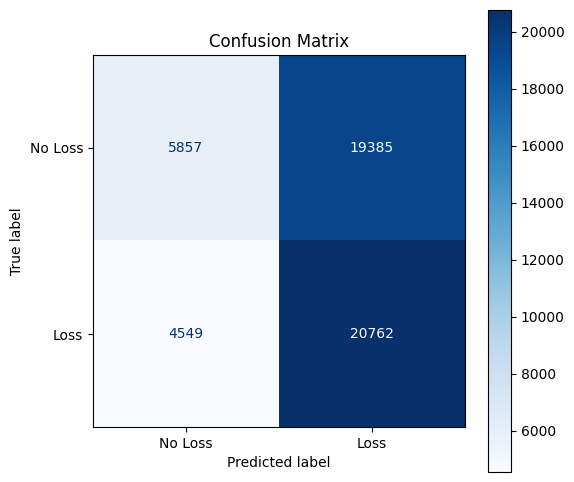


ROC AUC Score: 0.5577


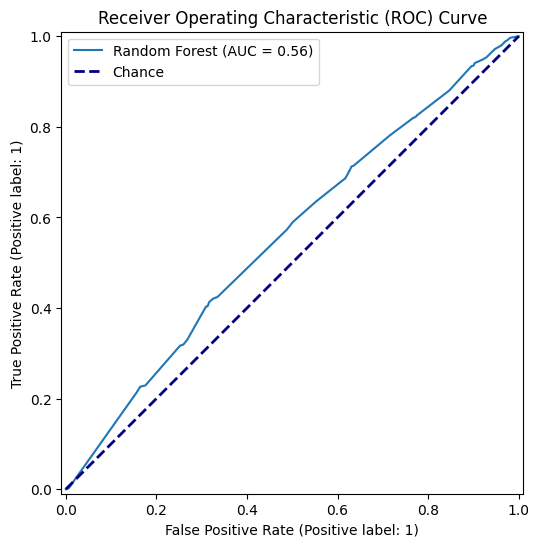

In [ ]:
if X_test.empty or y_test.empty:
    print("Test data is empty. Skipping evaluation.")
else:
    print("Evaluating model on the test set...")

    # Make predictions
    y_pred = rf_classifier.predict(X_test)
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1] # Probability of class 1 (loss)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Loss', 'Loss'], zero_division=0))

    print("\nConfusion Matrix:")
    try:
        cm = confusion_matrix(y_test, y_pred)
        print(cm)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Loss', 'Loss'])
        fig, ax = plt.subplots(figsize=(6, 6))
        disp.plot(cmap=plt.cm.Blues, ax=ax)
        plt.title('Confusion Matrix')
        plt.show()
    except Exception as e:
        print(f"Could not generate Confusion Matrix plot: {e}")


    # Check if both classes are present in y_test for ROC AUC calculation
    if len(np.unique(y_test)) > 1:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f"\nROC AUC Score: {roc_auc:.4f}")

        try:
            from sklearn.metrics import RocCurveDisplay
            fig, ax = plt.subplots(figsize=(6, 6))
            RocCurveDisplay.from_predictions(y_test, y_pred_proba, ax=ax, name='Random Forest')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend()
            plt.show()
        except Exception as e:
            print(f"Could not generate ROC Curve plot: {e}")
    else:
        print("\nROC AUC Score cannot be calculated: Only one class present in the test set.")

## 9. Feature Importance Analysis

Analyze the feature importances provided by the Random Forest model (based on mean decrease in impurity - Gini importance) to understand which variables were most influential in the model's predictions.g



Calculating and plotting Feature Importances...

Top 20 Feature Importances:
            Feature  Importance
0   lsat_SWIR1_2000    0.168173
1   lsat_SWIR2_2000    0.148072
2     lsat_NIR_2000    0.135395
3       precip_2000    0.111829
4     lsat_NBR_2000    0.068460
5   lsat_Green_2000    0.058703
6       precip_2001    0.053978
7     lsat_Red_2000    0.045894
8               dem    0.045054
9         temp_2001    0.038372
10            slope    0.034313
11   lsat_NDVI_2000    0.033911
12   lsat_Blue_2000    0.030581
13        temp_2000    0.027264
14        temp_2002    0.000000
15   lsat_Blue_2001    0.000000
16  lsat_Green_2001    0.000000
17    lsat_Red_2001    0.000000
18    lsat_NIR_2001    0.000000
19  lsat_SWIR1_2001    0.000000


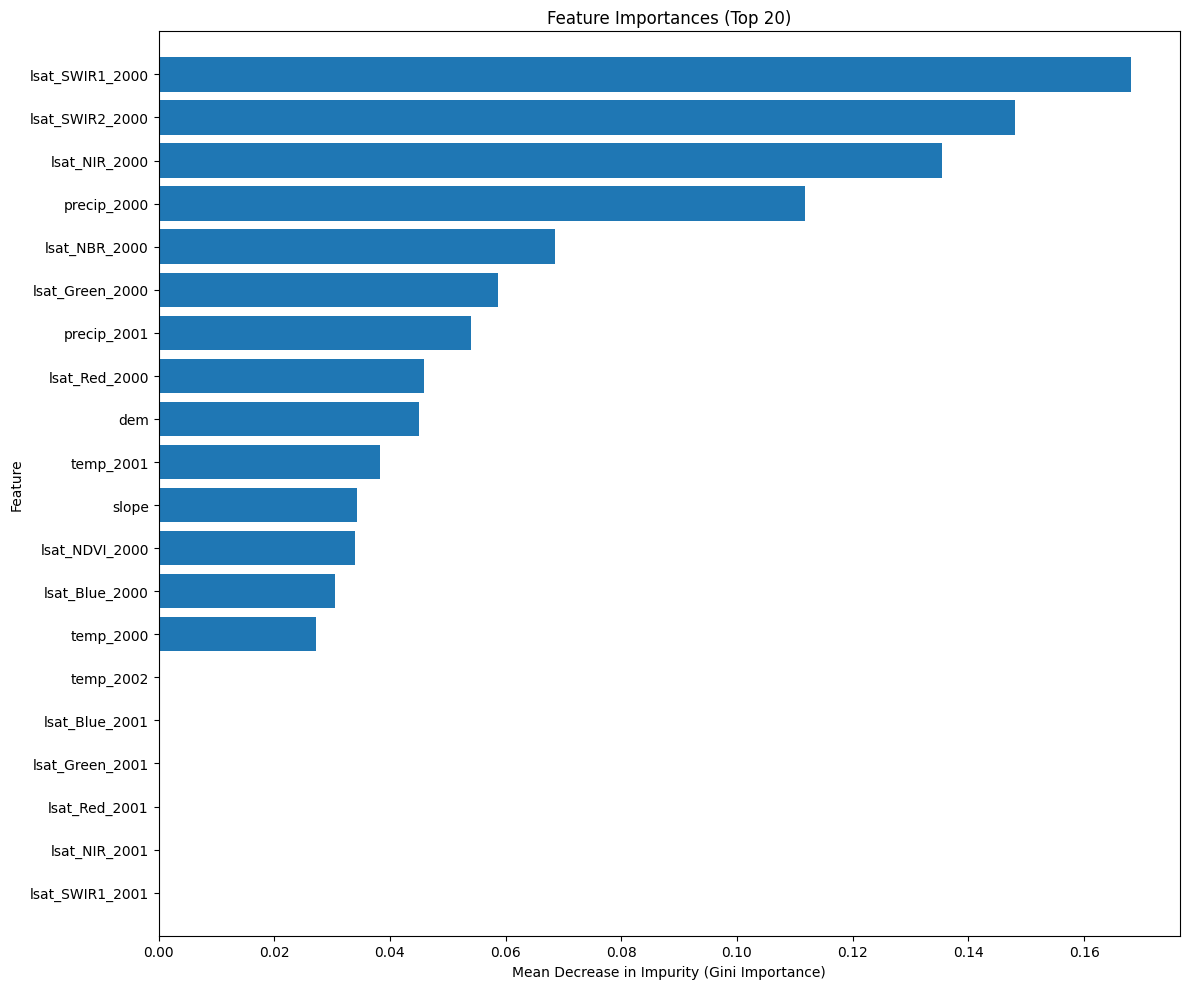

Feature importances saved to: /Users/benjaminpace/MLCS/mlcs/output/rf_feature_importances_2001_2002.csv


In [ ]:
print("Calculating and plotting Feature Importances...")

try:
    importances = rf_classifier.feature_importances_
    # Get standard deviations of importances across trees (optional, adds compute time)
    indices = np.argsort(importances)[::-1] # Sort features by importance (descending)

    importance_df = pd.DataFrame({
        'Feature': [FEATURE_NAMES[i] for i in indices],
        'Importance': importances[indices],
    })

    print("\nTop 20 Feature Importances:")
    print(importance_df.head(20))

    N_FEATURES_TO_PLOT = 20
    plt.figure(figsize=(12, max(6, N_FEATURES_TO_PLOT // 2))) 
    plt.title(f"Feature Importances (Top {N_FEATURES_TO_PLOT})")
    plt.barh(range(N_FEATURES_TO_PLOT),
             importance_df['Importance'].head(N_FEATURES_TO_PLOT)[::-1],
             align='center')
    plt.yticks(range(N_FEATURES_TO_PLOT),
               importance_df['Feature'].head(N_FEATURES_TO_PLOT)[::-1]) 
    plt.xlabel("Mean Decrease in Impurity (Gini Importance)")
    plt.ylabel("Feature")
    plt.ylim([-1, N_FEATURES_TO_PLOT])
    plt.tight_layout()
    plt.show()

    # Optional: Save importance data
    importance_filename = OUTPUT_DIR / f'rf_feature_importances_{START_YEAR}_{END_YEAR}.csv'
    importance_df.to_csv(importance_filename, index=False)
    print(f"Feature importances saved to: {importance_filename}")

except Exception as e:
    print(f"An error occurred during feature importance calculation or plotting: {e}")